ΚΑΡΛΗΣ ΝΙΚΟΛΑΟΣ 1115201800068


ΧΑΤΖΗΠΑΥΛΟΥ ΜΑΡΙΑ 1115201400223

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping



In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Διάβασμα του αρχείου με μετατροπή σε dataframe

In [ ]:
# read files
df = pd.read_csv('/content/gdrive/MyDrive/nasdaq2007_17.csv', header=None,sep = '\t')

df = df.reset_index(drop=True)

print("Number of rows and columns:", df.shape)

Number of rows and columns: (359, 3651)


In [ ]:
n = 5

In [ ]:
print(df)

     0        1        2        3     ...    3647    3648    3649    3650
0       a  11.1440  10.4710  10.8280  ...   68.25   68.11   67.47   66.81
1      aa  47.4580  45.8700  46.2490  ...   46.97   45.89   43.33   43.01
2    aaba  13.8800  12.9700  13.2900  ...   72.22   71.16   70.19   70.56
3    aapl   1.2037   1.1589   1.1385  ...  174.18  175.61  175.25  174.67
4     abc  13.9910  13.4340  13.1950  ...   74.91   75.01   75.27   75.00
..    ...      ...      ...      ...  ...     ...     ...     ...     ...
354  xray  17.2850  16.9010  17.0160  ...   64.38   64.52   65.56   65.58
355   xrx  36.3880  35.2030  35.7070  ...   28.59   29.37   29.27   29.17
356   yum   8.2660   8.3172   8.2781  ...   81.01   81.13   79.53   79.59
357   zbh  46.3950  45.8150  42.1810  ...  108.72  109.17  111.84  110.75
358  zion  47.6690  46.6680  46.5700  ...   44.88   44.55   43.97   43.93

[359 rows x 3651 columns]


In [ ]:
print(df.shape)

(359, 3651)


το df.shape[0] είναι το πλήθος των γραμμών και το df.shape[1] είναι το πλήθος των στηλών. 

Αφού πρέπει να χωρίσουμε κάθε time series σε 80% training set και 20% test set βρίσκουμε σε ποιο column του dataframe αντιστοιχεί το 80% του time series που είναι το df.shape[1] * 0.8

Αποθηκεύουμε το αποτέλεσμα στην μεταβλητή percentage

In [ ]:
rows = df.shape[0]
columns = df.shape[1] - 1

percentage = int(columns * 0.80)


Σκεφτήκαμε να εφαρμόσουμε τον κώδικα που μας δόθηκε αλλά αντί για ένα dataframe με μία στήλη με πολλές γραμμές έχουμε πολλές στήλες με πολλές γραμμές.


Ξεκινήσαμε να κάνουμε iterate κάθε γραμμή του dataframe με το iterrows(). Παρατηρήσαμε ότι με την χρήση του row εμφανίζονταν κάθετα τα δεδομένα της γραμμής, σαν στήλη, επομένως σε κάθε επανάληψη δημιουργούμε ένα temp dataframe που έχει τα time series κάθε γραμμής. Έτσι το dataframe temp είναι σαν αυτό που έχει στο παράδειγμα και μπορούμε δημιουργήσουμε σε κάθε επανάληψη τα αντίστοιχα X_train, y_train και y_test, και τα αποθηκεύουμε σε αντίστοιχες λίστες trainXList, trainYList και testList.

Το scale γίνεται ξεχωριστά σε κάθε γραμμή του dataframe

In [ ]:
trainXList = []
trainYList = []

testList = []

sc = MinMaxScaler(feature_range = (0, 1))

for index, row in df.iterrows():
  temp = pd.DataFrame(row[1:].astype(float))
  temp.columns = ['price']
  training_set = temp.iloc[:percentage].values
  test_set = temp.iloc[percentage:].values
  training_set_scaled = sc.fit_transform(training_set)
  trainingSize = training_set.shape[0]
  
  X_train = []
  y_train = []
  for i in range(60, (trainingSize)):
      X_train.append(training_set_scaled[i-60:i, 0])
      y_train.append(training_set_scaled[i, 0])
  X_train, y_train = np.array(X_train), np.array(y_train)

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  trainXList.append(X_train)
  trainYList.append(X_train)

  dataset_train = temp.iloc[:percentage]
  dataset_test = temp.iloc[percentage:]

  testSize = dataset_test.shape[0]
  
  dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

  inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

  inputs = inputs.reshape(-1,1)
  inputs = sc.transform(inputs)
  X_test = []
  for i in range(60, testSize+60):
      X_test.append(inputs[i-60:i, 0])

  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  testList.append(X_test)

In [ ]:
print(X_train.shape)

(2860, 60, 1)


Το μοντέλο που μας δόθηκε

In [ ]:
from keras.models import Sequential

model = Sequential()  # Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2)) # Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2)) # Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2)) # Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2)) # Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')



Κάνουμε επαναληπτικά fit το model για κάθε Χ_train, y_train που δημιουργήσαμε πριν και έχουμε αποθηκευμένα στις λίστες τις οποίες κάνουμε iterate. 

Το batch_size είναι 1024 που είναι το μεγαλύτερο δυνατό.

Επιλέχθηκε μεγάλο batch_size επειδή κάνουμε πολλές φορές fit το μοντέλο και είναι πιο γρήγορο στην εκπαίδευση με μεγάλο batch_size αλλά επειδή εκπαιδεύεται πολλές φορές δεν θα έχει μεγάλο πρόβλημα στην ακρίβεια του μοντέλου.

Ο αριθμός των epochs είναι 5. Δεν χρειαζόμαστε πολλά epochs διότι εφαρμόζουμε το μοντέλο, 360 φορές για αυτό επιλέξαμε μικρό αριθμό, αφού θα έχουμε 1500 epochs συνολικά


In [ ]:
for X_train, y_train in zip(trainXList, trainYList):
  # Fitting the RNN to the Training set
  model.fit(X_train, y_train, epochs = 5, batch_size = 1024)

Epoch 1/5
3/3 [==============================] - 8s 52ms/step - loss: 0.2125
Epoch 2/5
3/3 [==============================] - 0s 51ms/step - loss: 0.0619
Epoch 3/5
3/3 [==============================] - 0s 35ms/step - loss: 0.0433
Epoch 4/5
3/3 [==============================] - 0s 34ms/step - loss: 0.0180
Epoch 5/5
3/3 [==============================] - 0s 33ms/step - loss: 0.0267
Epoch 1/5
3/3 [==============================] - 0s 32ms/step - loss: 0.0212
Epoch 2/5
3/3 [==============================] - 0s 32ms/step - loss: 0.0137
Epoch 3/5
3/3 [==============================] - 0s 33ms/step - loss: 0.0146
Epoch 4/5
3/3 [==============================] - 0s 32ms/step - loss: 0.0110
Epoch 5/5
3/3 [==============================] - 0s 31ms/step - loss: 0.0076
Epoch 1/5
3/3 [==============================] - 0s 32ms/step - loss: 0.0053
Epoch 2/5
3/3 [==============================] - 0s 32ms/step - loss: 0.0047
Epoch 3/5
3/3 [==============================] - 0s 32ms/step - loss: 0.0045

In [ ]:
print(len(testList))

359


In [ ]:
# Calling save('model1') creates a SavedModel folder model1
model.save('/content/gdrive/MyDrive/model1')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model1/assets


Κάνουμε visualize τα Real Stock Price και τα Predicted Stock Price για ορισμένες μετοχές

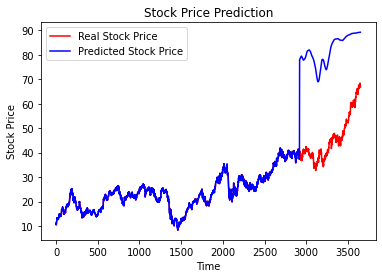

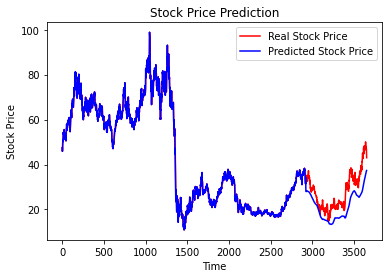

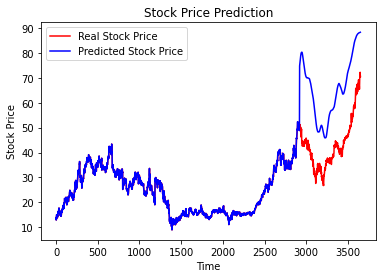

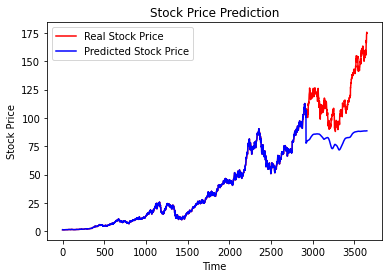

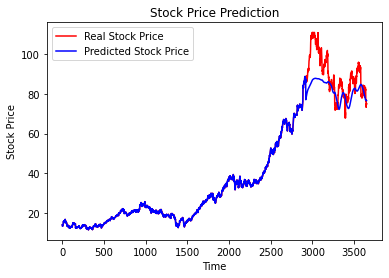

In [ ]:
for index, X_test in enumerate(testList):
  if(index < n):

    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)


    df2 = pd.DataFrame(predicted_stock_price)

    frames = [df.loc[index][1:percentage+1], df2]
  
    result = pd.concat(frames)
    
    # Visualising the results
    plt.plot(df.loc[index][1:], color = 'red', label = 'Real Stock Price')
    plt.plot(result.values, color = 'blue', label = 'Predicted Stock Price') #, predicted_stock_price,
    # plt.xticks(np.arange(0,459,50))
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
